# Predicao do Preco de Fechamento da PETR4.SA com LSTM

## Projeto de Deep Learning aplicado a Series Temporais Financeiras

**Autor:** Guilherme de Mauro Favaron

---

### Sobre este notebook

Este notebook implementa um modelo preditivo de redes neurais **Long Short-Term Memory (LSTM)** para prever o preco de fechamento das acoes da **Petrobras (PETR4.SA)** na bolsa de valores brasileira.

O objetivo e construir toda a pipeline de desenvolvimento, desde a coleta dos dados ate a exportacao do modelo treinado para uso em producao.

### O que voce vai aprender aqui

1. Como coletar dados financeiros usando a biblioteca `yfinance`
2. Como preparar dados de series temporais para alimentar uma LSTM
3. Como construir e treinar um modelo LSTM em PyTorch
4. Como avaliar o modelo com metricas apropriadas (MAE, RMSE, MAPE)
5. Como exportar o modelo treinado para uso em uma API

### Pre-requisitos

- Conhecimento basico de Python
- Nocoes de Machine Learning (o que e treino, validacao, teste)
- Este notebook roda no **Google Colab** com GPU gratuita (tambem funciona localmente com CUDA ou Apple Silicon MPS)

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Configuracao do Ambiente

Primeiro, vamos instalar e importar todas as bibliotecas necessarias.

**Por que essas bibliotecas?**
- `yfinance`: faz download de dados historicos de acoes direto do Yahoo Finance
- `torch` (PyTorch): framework de deep learning que usaremos para construir a LSTM
- `sklearn`: usaremos o `MinMaxScaler` para normalizar os dados
- `matplotlib` / `plotly`: para visualizacoes graficas
- `pandas` / `numpy`: manipulacao de dados

In [1]:
# Instalacao das dependencias (necessario no Colab)
!pip install yfinance plotly -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import json
import os
import warnings
import time
from datetime import datetime

warnings.filterwarnings('ignore')

# Detectar melhor dispositivo disponivel:
# - CUDA para GPUs NVIDIA (Colab T4, etc.)
# - MPS para Apple Silicon (M1/M2/M3)
# - CPU como fallback
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Dispositivo: {device} ({torch.cuda.get_device_name(0)})')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Dispositivo: {device} (Apple Silicon GPU)')
else:
    device = torch.device('cpu')
    print(f'Dispositivo: {device}')

# Seed para reproducibilidade
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Dispositivo: cpu


## 2. Coleta dos Dados

Vamos baixar o historico de precos da **PETR4.SA** (Petrobras) usando a biblioteca `yfinance`.

**O que sao esses dados?**
Cada linha representa um dia de negociacao na bolsa e contem:
- **Open**: preco de abertura do dia
- **High**: preco mais alto atingido no dia
- **Low**: preco mais baixo atingido no dia
- **Close**: preco de fechamento do dia (nosso **alvo de predicao**)
- **Volume**: quantidade de acoes negociadas
- **Adj Close**: preco de fechamento ajustado (considera dividendos e splits)

Usaremos dados de **janeiro de 2018 ate hoje**, o que nos da varios anos de historico para o modelo aprender padroes.

In [3]:
# Configuracao da coleta
SYMBOL = 'PETR4.SA'       # Ticker da Petrobras na B3
START_DATE = '2018-01-01'  # Data inicial
END_DATE = datetime.now().strftime('%Y-%m-%d')  # Ate hoje

print(f'Baixando dados de {SYMBOL}...')
print(f'Periodo: {START_DATE} ate {END_DATE}')

# Download dos dados
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)

# Flatten MultiIndex columns if present (yfinance >= 0.2.31)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f'\nDados baixados com sucesso!')
print(f'Total de registros: {len(df)}')
print(f'Periodo coberto: {df.index.min().date()} ate {df.index.max().date()}')
print(f'\nPrimeiras linhas:')
df.head()

Baixando dados de PETR4.SA...
Periodo: 2018-01-01 ate 2026-02-14


[*********************100%***********************]  1 of 1 completed


Dados baixados com sucesso!
Total de registros: 2019
Periodo coberto: 2018-01-02 ate 2026-02-13

Primeiras linhas:


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,4.409358,4.409358,4.313444,4.313444,33461800
2018-01-03,4.449322,4.454650,4.361402,4.393372,55940900
2018-01-04,4.457315,4.518593,4.428008,4.470637,37064900
2018-01-05,4.483956,4.491949,4.414685,4.449321,26958200
2018-01-08,4.537243,4.537243,4.451986,4.459979,28400000


In [4]:
# Informacoes gerais do dataset
print('=== Informacoes do Dataset ===')
print(f'Shape: {df.shape}')
print(f'\nTipos de dados:')
print(df.dtypes)
print(f'\nValores nulos por coluna:')
print(df.isnull().sum())
print(f'\nEstatisticas descritivas:')
df.describe()

=== Informacoes do Dataset ===
Shape: (2019, 5)

Tipos de dados:
Price
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Valores nulos por coluna:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Estatisticas descritivas:


Price,Close,High,Low,Open,Volume
count,2019.000000,2019.000000,2019.000000,2019.000000,2.019000e+03
mean,15.558639,15.752554,15.366477,15.560219,6.038445e+07
std,10.190894,10.273539,10.109245,10.188800,3.531645e+07
min,3.242130,3.497710,3.115775,3.178952,0.000000e+00
25%,7.133182,7.224592,7.027058,7.146808,3.659720e+07
50%,11.221379,11.337974,11.044719,11.200178,5.345620e+07
75%,27.788872,28.105838,27.541259,27.827043,7.410095e+07
max,38.080002,38.580002,37.689999,38.049999,4.902304e+08


## 3. Analise Exploratoria dos Dados (EDA)

Antes de construir o modelo, precisamos entender os dados. Vamos visualizar:
1. A evolucao do preco ao longo do tempo
2. O volume de negociacao
3. A distribuicao dos retornos diarios
4. A volatilidade

Isso nos ajuda a entender o comportamento da serie temporal e validar se uma LSTM e uma boa abordagem.

In [5]:
# Grafico interativo com Plotly: Preco de fechamento + Volume
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    row_heights=[0.7, 0.3],
    subplot_titles=(
        f'Preco de Fechamento - {SYMBOL}',
        'Volume de Negociacao'
    )
)

# Preco de fechamento
fig.add_trace(
    go.Scatter(
        x=df.index, y=df['Close'],
        mode='lines', name='Close',
        line=dict(color='#1f77b4', width=1.5)
    ),
    row=1, col=1
)

# Media movel de 50 dias
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

fig.add_trace(
    go.Scatter(
        x=df.index, y=df['MA50'],
        mode='lines', name='Media Movel 50d',
        line=dict(color='orange', width=1, dash='dash')
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df.index, y=df['MA200'],
        mode='lines', name='Media Movel 200d',
        line=dict(color='red', width=1, dash='dash')
    ),
    row=1, col=1
)

# Volume
fig.add_trace(
    go.Bar(
        x=df.index, y=df['Volume'],
        name='Volume',
        marker_color='rgba(31, 119, 180, 0.4)'
    ),
    row=2, col=1
)

fig.update_layout(
    height=700,
    showlegend=True,
    title_text=f'Analise Historica - {SYMBOL}',
    xaxis2_title='Data',
    yaxis_title='Preco (BRL)',
    yaxis2_title='Volume'
)

fig.show()

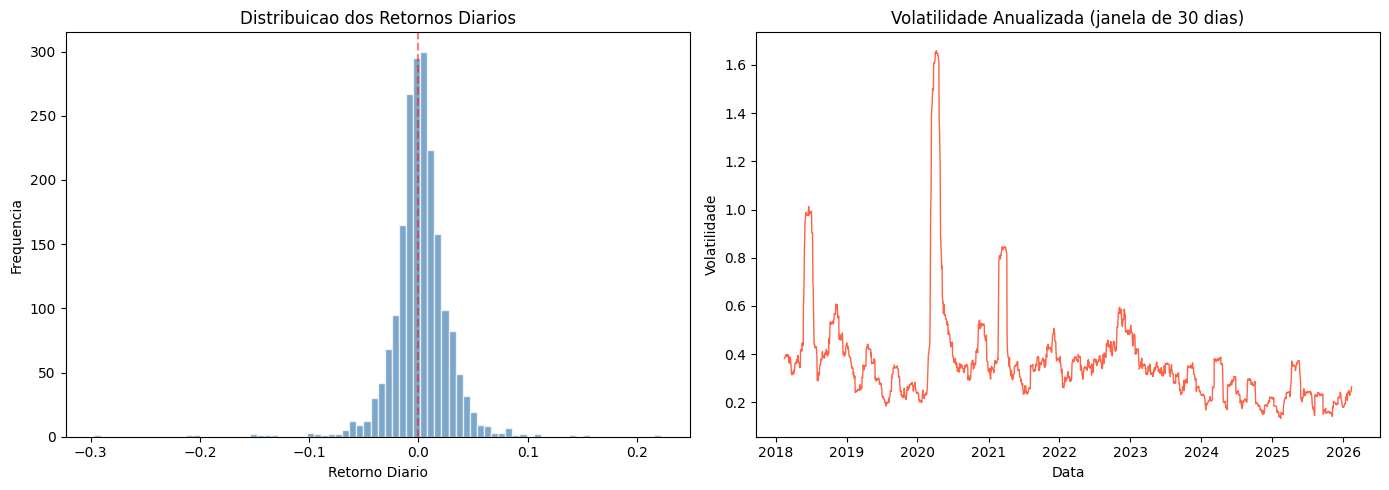

Retorno medio diario: 0.0014 (0.14%)
Desvio padrao dos retornos: 0.0263
Retorno acumulado no periodo: 736.6%


In [6]:
# Retornos diarios (variacao percentual dia a dia)
df['Returns'] = df['Close'].pct_change()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma dos retornos
axes[0].hist(df['Returns'].dropna(), bins=80, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].set_title('Distribuicao dos Retornos Diarios')
axes[0].set_xlabel('Retorno Diario')
axes[0].set_ylabel('Frequencia')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Volatilidade (rolling std dos retornos)
volatility = df['Returns'].rolling(window=30).std() * np.sqrt(252)  # Anualizada
axes[1].plot(df.index, volatility, color='tomato', linewidth=1)
axes[1].set_title('Volatilidade Anualizada (janela de 30 dias)')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Volatilidade')

plt.tight_layout()
plt.show()

print(f'Retorno medio diario: {df["Returns"].mean():.4f} ({df["Returns"].mean()*100:.2f}%)')
print(f'Desvio padrao dos retornos: {df["Returns"].std():.4f}')
print(f'Retorno acumulado no periodo: {((df["Close"].iloc[-1] / df["Close"].iloc[0]) - 1)*100:.1f}%')

## 4. Pre-processamento dos Dados

Agora vamos preparar os dados para alimentar a LSTM. Essa etapa e **crucial** e envolve:

### 4.1 Por que normalizar?
Redes neurais funcionam melhor quando os dados estao numa escala entre 0 e 1. O `MinMaxScaler` faz essa transformacao. Sem isso, o modelo teria dificuldade para convergir.

### 4.2 O que sao janelas deslizantes (sliding windows)?
A LSTM precisa receber uma **sequencia** de valores passados para prever o proximo. Por exemplo, se usarmos uma janela de 60 dias:
- **Entrada (X)**: precos dos dias 1 ao 60
- **Saida (y)**: preco do dia 61
- Depois: entrada = dias 2 ao 61, saida = dia 62, e assim por diante.

### 4.3 Split temporal
Em series temporais, **nunca embaralhamos os dados**. O split deve respeitar a ordem cronologica:
- **Treino**: primeiros 70% dos dados
- **Validacao**: proximos 15%
- **Teste**: ultimos 15%

In [7]:
# === CONFIGURACOES DO PRE-PROCESSAMENTO ===
SEQUENCE_LENGTH = 60   # Quantos dias passados usamos para prever o proximo
FEATURE_COLUMNS = ['Close']  # Coluna(s) que usaremos como features
TARGET_COLUMN = 'Close'      # Coluna que queremos prever

# Proporcion do split
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f'Janela de lookback: {SEQUENCE_LENGTH} dias')
print(f'Features: {FEATURE_COLUMNS}')
print(f'Target: {TARGET_COLUMN}')
print(f'Split: {TRAIN_RATIO*100:.0f}% treino / {VAL_RATIO*100:.0f}% validacao / {TEST_RATIO*100:.0f}% teste')

Janela de lookback: 60 dias
Features: ['Close']
Target: Close
Split: 70% treino / 15% validacao / 15% teste


In [8]:
# Selecionar apenas a coluna de fechamento e remover nulos
data = df[FEATURE_COLUMNS].dropna().values

print(f'Total de amostras disponiveis: {len(data)}')

# === NORMALIZACAO ===
# O MinMaxScaler transforma os valores para o intervalo [0, 1]
# Exemplo: se o preco varia de R$10 a R$40, R$25 vira 0.5
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

print(f'Valor minimo original: R${data.min():.2f}')
print(f'Valor maximo original: R${data.max():.2f}')
print(f'Apos normalizacao: min={data_scaled.min():.4f}, max={data_scaled.max():.4f}')

Total de amostras disponiveis: 2019
Valor minimo original: R$3.24
Valor maximo original: R$38.08
Apos normalizacao: min=0.0000, max=1.0000


In [9]:
def create_sequences(data, sequence_length):
    """
    Cria sequencias de entrada (X) e saidas (y) para a LSTM.
    
    Parametros:
        data: array normalizado com os precos
        sequence_length: quantos dias passados usar como entrada
    
    Retorna:
        X: array de shape (n_amostras, sequence_length, n_features)
        y: array de shape (n_amostras, 1)
    
    Exemplo com sequence_length=3 e dados [10, 20, 30, 40, 50]:
        X[0] = [10, 20, 30] -> y[0] = 40
        X[1] = [20, 30, 40] -> y[1] = 50
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length, 0])  # Coluna 0 = Close
    return np.array(X), np.array(y)

# Criar as sequencias
X, y = create_sequences(data_scaled, SEQUENCE_LENGTH)

print(f'Shape de X: {X.shape}  (amostras, janela_temporal, features)')
print(f'Shape de y: {y.shape}  (amostras,)')
print(f'\nExemplo: para prever o preco do dia {SEQUENCE_LENGTH+1},') 
print(f'o modelo recebe os precos (normalizados) dos {SEQUENCE_LENGTH} dias anteriores.')

Shape de X: (1959, 60, 1)  (amostras, janela_temporal, features)
Shape de y: (1959,)  (amostras,)

Exemplo: para prever o preco do dia 61,
o modelo recebe os precos (normalizados) dos 60 dias anteriores.


In [10]:
# === SPLIT TEMPORAL ===
# IMPORTANTE: nao embaralhamos! A ordem cronologica deve ser mantida.

n_total = len(X)
n_train = int(n_total * TRAIN_RATIO)
n_val = int(n_total * VAL_RATIO)
n_test = n_total - n_train - n_val

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

print(f'Conjunto de Treino:    {len(X_train)} amostras ({len(X_train)/n_total*100:.1f}%)')
print(f'Conjunto de Validacao: {len(X_val)} amostras ({len(X_val)/n_total*100:.1f}%)')
print(f'Conjunto de Teste:     {len(X_test)} amostras ({len(X_test)/n_total*100:.1f}%)')

# Converter para tensores PyTorch
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.FloatTensor(y_val).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.FloatTensor(y_test).to(device)

# Criar DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'\nBatch size: {BATCH_SIZE}')
print(f'Batches de treino: {len(train_loader)}')

Conjunto de Treino:    1371 amostras (70.0%)
Conjunto de Validacao: 293 amostras (15.0%)
Conjunto de Teste:     295 amostras (15.1%)

Batch size: 32
Batches de treino: 43


## 5. Construcao do Modelo LSTM

### O que e uma LSTM?

**LSTM (Long Short-Term Memory)** e um tipo especial de rede neural recorrente (RNN) projetada para aprender dependencias de longo prazo em sequencias de dados.

Uma LSTM possui tres "portoes" (gates) que controlam o fluxo de informacao:
- **Forget Gate**: decide o que esquecer do estado anterior
- **Input Gate**: decide quais novas informacoes armazenar
- **Output Gate**: decide o que enviar como saida

Isso permite que a rede "lembre" padroes de muitos dias atras, algo essencial para series temporais financeiras.

### Arquitetura do nosso modelo

```
Input (60 dias, 1 feature)
    |
    v
LSTM Layer 1 (128 unidades) + Dropout(0.2)
    |
    v
LSTM Layer 2 (64 unidades) + Dropout(0.2)
    |
    v
Fully Connected (64 -> 32)
    |
    v
Output (32 -> 1) = Preco previsto
```

In [11]:
class LSTMModel(nn.Module):
    """
    Modelo LSTM para predicao de series temporais financeiras.
    
    Parametros:
        input_size: numero de features de entrada (1 = apenas Close)
        hidden_size: numero de neuronios na camada LSTM
        num_layers: numero de camadas LSTM empilhadas
        dropout: taxa de dropout para regularizacao (evita overfitting)
    """
    
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Camadas LSTM empilhadas
        # batch_first=True: formato de entrada sera (batch, sequencia, features)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Camadas fully connected para gerar a previsao final
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        # Inicializar estados ocultos com zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Passar pela LSTM
        # lstm_out contem as saidas de todos os timesteps
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Pegar apenas a saida do ultimo timestep
        # (queremos a previsao baseada em toda a sequencia)
        last_output = lstm_out[:, -1, :]
        
        # Passar pelas camadas fully connected
        prediction = self.fc(last_output)
        
        return prediction

In [12]:
# === HIPERPARAMETROS ===
HIDDEN_SIZE = 128      # Neuronios na LSTM
NUM_LAYERS = 2         # Camadas LSTM
DROPOUT = 0.2          # Taxa de dropout
LEARNING_RATE = 0.001  # Taxa de aprendizado
NUM_EPOCHS = 100       # Numero maximo de epocas
PATIENCE = 15          # Early stopping: para se nao melhorar em 15 epocas

# Criar o modelo
model = LSTMModel(
    input_size=len(FEATURE_COLUMNS),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Funcao de perda e otimizador
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler: reduz o LR quando o modelo para de melhorar
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Resumo do modelo
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('=== Arquitetura do Modelo ===')
print(model)
print(f'\nTotal de parametros: {total_params:,}')
print(f'Parametros treinaveis: {trainable_params:,}')

=== Arquitetura do Modelo ===
LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total de parametros: 209,537
Parametros treinaveis: 209,537


## 6. Treinamento do Modelo

Agora vamos treinar o modelo. Durante o treinamento:

1. O modelo recebe batches de sequencias de 60 dias
2. Faz uma previsao para o dia seguinte
3. Compara a previsao com o valor real (calcula a perda/loss)
4. Ajusta os pesos via backpropagation
5. Repete para todos os batches (1 epoca)

Usamos **Early Stopping**: se a perda no conjunto de validacao nao melhorar por 15 epocas seguidas, paramos o treinamento para evitar overfitting.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, patience, device):
    """
    Treina o modelo LSTM com early stopping.
    
    Retorna:
        model: modelo com os melhores pesos
        history: dicionario com historico de loss de treino e validacao
    """
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # === TREINO ===
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            
            # Gradient clipping para estabilidade
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        
        # === VALIDACAO ===
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                loss = criterion(predictions, y_batch)
                val_losses.append(loss.item())
        
        avg_val_loss = np.mean(val_losses)
        
        # Registrar historico
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        # Atualizar learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
            marker = ' <-- melhor'
        else:
            epochs_without_improvement += 1
            marker = ''
        
        # Log a cada 10 epocas ou na ultima
        if (epoch + 1) % 10 == 0 or epoch == 0 or marker:
            elapsed = time.time() - start_time
            print(f'Epoca [{epoch+1:3d}/{num_epochs}] '
                  f'Train Loss: {avg_train_loss:.6f} | '
                  f'Val Loss: {avg_val_loss:.6f} | '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f} | '
                  f'Tempo: {elapsed:.0f}s{marker}')
        
        if epochs_without_improvement >= patience:
            print(f'\nEarly stopping na epoca {epoch+1}! '
                  f'Sem melhoria ha {patience} epocas.')
            break
    
    # Carregar os melhores pesos
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'\nMelhores pesos restaurados (val_loss: {best_val_loss:.6f})')
    
    total_time = time.time() - start_time
    print(f'Treinamento concluido em {total_time:.1f} segundos.')
    
    return model, history

# === TREINAR ===
print('Iniciando treinamento...\n')
model, history = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    NUM_EPOCHS, PATIENCE, device
)

Iniciando treinamento...

Epoca [  1/100] Train Loss: 0.012518 | Val Loss: 0.155842 | LR: 0.001000 | Tempo: 4s <-- melhor


In [ ]:
# Visualizar curva de treinamento
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(history['train_loss'], label='Treino', color='steelblue', linewidth=2)
ax.plot(history['val_loss'], label='Validacao', color='tomato', linewidth=2)
ax.set_title('Curva de Treinamento (Loss)', fontsize=14)
ax.set_xlabel('Epoca')
ax.set_ylabel('MSE Loss')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Loss final de treino: {history["train_loss"][-1]:.6f}')
print(f'Melhor loss de validacao: {min(history["val_loss"]):.6f}')

## 7. Avaliacao do Modelo

Vamos avaliar o modelo no **conjunto de teste** (dados que ele nunca viu durante o treinamento).

Usaremos tres metricas:

- **MAE (Mean Absolute Error)**: media dos erros absolutos. Ex: MAE = 1.5 significa que, em media, a previsao erra R$1.50.
- **RMSE (Root Mean Square Error)**: raiz da media dos erros ao quadrado. Penaliza mais os erros grandes.
- **MAPE (Mean Absolute Percentage Error)**: erro medio em percentual. Ex: MAPE = 3% significa que a previsao erra, em media, 3% do valor real.

In [ ]:
def evaluate_model(model, X_tensor, y_tensor, scaler, device):
    """
    Avalia o modelo e retorna previsoes desnormalizadas + metricas.
    """
    model.eval()
    with torch.no_grad():
        predictions_scaled = model(X_tensor).cpu().numpy().flatten()
    
    y_true_scaled = y_tensor.cpu().numpy().flatten()
    
    # Desnormalizar: voltar para a escala original (BRL)
    # Precisamos reshape para o scaler aceitar
    predictions_real = scaler.inverse_transform(
        predictions_scaled.reshape(-1, 1)
    ).flatten()
    
    y_true_real = scaler.inverse_transform(
        y_true_scaled.reshape(-1, 1)
    ).flatten()
    
    # Calcular metricas
    mae = mean_absolute_error(y_true_real, predictions_real)
    rmse = np.sqrt(mean_squared_error(y_true_real, predictions_real))
    mape = np.mean(np.abs((y_true_real - predictions_real) / y_true_real)) * 100
    
    metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
    
    return predictions_real, y_true_real, metrics

# Avaliar no conjunto de teste
test_pred, test_true, test_metrics = evaluate_model(
    model, X_test_t, y_test_t, scaler, device
)

print('=== METRICAS NO CONJUNTO DE TESTE ===')
print(f'MAE  (Erro Absoluto Medio):     R$ {test_metrics["MAE"]:.2f}')
print(f'RMSE (Raiz do Erro Quadratico): R$ {test_metrics["RMSE"]:.2f}')
print(f'MAPE (Erro Percentual Medio):   {test_metrics["MAPE"]:.2f}%')

# Avaliar tambem treino e validacao para comparacao
train_pred, train_true, train_metrics = evaluate_model(
    model, X_train_t, y_train_t, scaler, device
)
val_pred, val_true, val_metrics = evaluate_model(
    model, X_val_t, y_val_t, scaler, device
)

print(f'\n=== COMPARATIVO ===')
print(f'{"Metrica":<8} {"Treino":>10} {"Validacao":>10} {"Teste":>10}')
print(f'{"-"*40}')
for m in ['MAE', 'RMSE', 'MAPE']:
    unit = '%' if m == 'MAPE' else ''
    prefix = '' if m == 'MAPE' else 'R$ '
    print(f'{m:<8} {prefix}{train_metrics[m]:>8.2f}{unit} {prefix}{val_metrics[m]:>8.2f}{unit} {prefix}{test_metrics[m]:>8.2f}{unit}')

In [ ]:
# === GRAFICO: Real vs Previsto (Teste) ===
fig = go.Figure()

# Obter as datas correspondentes ao conjunto de teste
test_dates = df.index[n_train + n_val + SEQUENCE_LENGTH:n_train + n_val + SEQUENCE_LENGTH + len(test_true)]

fig.add_trace(go.Scatter(
    x=test_dates, y=test_true,
    mode='lines', name='Valor Real',
    line=dict(color='#1f77b4', width=2)
))

fig.add_trace(go.Scatter(
    x=test_dates, y=test_pred,
    mode='lines', name='Previsao LSTM',
    line=dict(color='#ff7f0e', width=2, dash='dash')
))

fig.update_layout(
    title=f'Conjunto de Teste: Real vs Previsto - {SYMBOL}',
    xaxis_title='Data',
    yaxis_title='Preco (BRL)',
    height=500,
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01)
)

fig.show()

In [ ]:
# === GRAFICO COMPLETO: Treino + Validacao + Teste ===
fig = go.Figure()

# Datas para cada conjunto
train_dates = df.index[SEQUENCE_LENGTH:SEQUENCE_LENGTH + len(train_true)]
val_dates = df.index[n_train + SEQUENCE_LENGTH:n_train + SEQUENCE_LENGTH + len(val_true)]

# Valores reais completos
all_dates = df.index[SEQUENCE_LENGTH:SEQUENCE_LENGTH + len(train_true) + len(val_true) + len(test_true)]
all_true = np.concatenate([train_true, val_true, test_true])

fig.add_trace(go.Scatter(
    x=all_dates, y=all_true,
    mode='lines', name='Valor Real',
    line=dict(color='#1f77b4', width=1.5)
))

# Previsoes por conjunto
fig.add_trace(go.Scatter(
    x=train_dates, y=train_pred,
    mode='lines', name='Previsao (Treino)',
    line=dict(color='green', width=1, dash='dot'),
    opacity=0.6
))

fig.add_trace(go.Scatter(
    x=val_dates, y=val_pred,
    mode='lines', name='Previsao (Validacao)',
    line=dict(color='orange', width=1.5, dash='dash')
))

fig.add_trace(go.Scatter(
    x=test_dates, y=test_pred,
    mode='lines', name='Previsao (Teste)',
    line=dict(color='red', width=2, dash='dash')
))

# Linhas verticais separando os conjuntos
# Usar add_shape + add_annotation para evitar bug do Plotly com Pandas Timestamps
y_min = float(all_true.min()) * 0.95
y_max = float(all_true.max()) * 1.05

for date, label in [(val_dates[0], 'Inicio Validacao'), (test_dates[0], 'Inicio Teste')]:
    fig.add_shape(
        type='line',
        x0=date, x1=date, y0=y_min, y1=y_max,
        line=dict(color='gray', dash='dash', width=1),
        opacity=0.5
    )
    fig.add_annotation(
        x=date, y=y_max, text=label,
        showarrow=False, yshift=10,
        font=dict(size=10, color='gray')
    )

fig.update_layout(
    title=f'Visao Completa: Real vs Previsto - {SYMBOL}',
    xaxis_title='Data',
    yaxis_title='Preco (BRL)',
    height=600,
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01)
)

fig.show()

## 8. Salvamento e Exportacao do Modelo

Agora que temos um modelo treinado e avaliado, vamos salvar tudo que e necessario para usa-lo em producao:

1. **Pesos do modelo** (`lstm_model.pth`): os parametros aprendidos pela rede
2. **Scaler** (`scaler.joblib`): o MinMaxScaler ajustado, necessario para normalizar novos dados
3. **Configuracao** (`config.json`): hiperparametros e metricas, para reconstruir o modelo

In [ ]:
# Criar diretorio de saida
MODELS_DIR = 'models'
os.makedirs(MODELS_DIR, exist_ok=True)

# 1. Salvar pesos do modelo
model_path = os.path.join(MODELS_DIR, 'lstm_model.pth')
torch.save(model.state_dict(), model_path)
print(f'Modelo salvo em: {model_path}')

# 2. Salvar o scaler
scaler_path = os.path.join(MODELS_DIR, 'scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f'Scaler salvo em: {scaler_path}')

# 3. Salvar configuracao completa
# Funcao auxiliar para converter numpy types para Python nativos (json.dump nao aceita numpy)
def to_python(val):
    if hasattr(val, 'item'):
        return val.item()
    return float(val)

config = {
    'model': {
        'input_size': len(FEATURE_COLUMNS),
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'sequence_length': SEQUENCE_LENGTH
    },
    'training': {
        'symbol': SYMBOL,
        'start_date': START_DATE,
        'end_date': END_DATE,
        'feature_columns': FEATURE_COLUMNS,
        'target_column': TARGET_COLUMN,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs_run': len(history['train_loss']),
        'train_ratio': TRAIN_RATIO,
        'val_ratio': VAL_RATIO,
        'test_ratio': TEST_RATIO
    },
    'metrics': {
        'test': {k: round(to_python(v), 4) for k, v in test_metrics.items()},
        'validation': {k: round(to_python(v), 4) for k, v in val_metrics.items()},
        'train': {k: round(to_python(v), 4) for k, v in train_metrics.items()}
    },
    'data_info': {
        'total_samples': len(data),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'scaler_min': float(scaler.data_min_[0]),
        'scaler_max': float(scaler.data_max_[0])
    },
    'exported_at': datetime.now().isoformat()
}

config_path = os.path.join(MODELS_DIR, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f'Configuracao salva em: {config_path}')

# Verificar tamanhos
for fname in os.listdir(MODELS_DIR):
    fpath = os.path.join(MODELS_DIR, fname)
    size_kb = os.path.getsize(fpath) / 1024
    print(f'  {fname}: {size_kb:.1f} KB')

In [ ]:
# === VERIFICACAO: carregar o modelo salvo e confirmar que funciona ===

# Reconstruir o modelo do zero
model_loaded = LSTMModel(
    input_size=config['model']['input_size'],
    hidden_size=config['model']['hidden_size'],
    num_layers=config['model']['num_layers'],
    dropout=config['model']['dropout']
).to(device)

# Carregar os pesos salvos
model_loaded.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model_loaded.eval()

# Testar com uma amostra
with torch.no_grad():
    sample_input = X_test_t[:1]  # Primeira amostra do teste
    prediction_original = model(sample_input).item()
    prediction_loaded = model_loaded(sample_input).item()

# Desnormalizar
pred_brl = scaler.inverse_transform([[prediction_loaded]])[0][0]

print('=== Verificacao do Modelo Salvo ===')
print(f'Previsao modelo original: {prediction_original:.6f}')
print(f'Previsao modelo carregado: {prediction_loaded:.6f}')
print(f'Previsoes identicas: {abs(prediction_original - prediction_loaded) < 1e-6}')
print(f'Valor previsto (BRL): R$ {pred_brl:.2f}')

## 9. Conclusao

### O que fizemos neste notebook:

1. **Coletamos** dados historicos da PETR4.SA usando o Yahoo Finance
2. **Exploramos** os dados com graficos de preco, volume, retornos e volatilidade
3. **Pre-processamos** os dados: normalizacao, criacao de janelas deslizantes e split temporal
4. **Construimos** um modelo LSTM com 2 camadas em PyTorch
5. **Treinamos** com early stopping e learning rate scheduling
6. **Avaliamos** com MAE, RMSE e MAPE no conjunto de teste
7. **Exportamos** o modelo, scaler e configuracao para uso em producao

### Proximos passos:

Os artefatos exportados (`lstm_model.pth`, `scaler.joblib`, `config.json`) serao usados pela API FastAPI + Gradio que servira as previsoes em tempo real no HuggingFace Spaces.

### Limitacoes importantes:

- Este modelo e **educacional** e nao deve ser usado como base para decisoes financeiras reais
- Precos de acoes sao influenciados por fatores externos (noticias, politica, macroeconomia) que nao estao capturados nos dados historicos
- A performance passada nao garante performance futura

---

*Projeto de Deep Learning aplicado a Series Temporais Financeiras | Guilherme Favaron*